
# 🧠 Robust Multimodal Emotion & Strategy Classifier (ResNet + Audio + Text)

This notebook includes:
- Balanced CSV loading  
- Safe image/audio reading (graceful failure logging)  
- Debug mode with `num_workers=0`  
- Full train/val loop  
- Save and reload trained model


In [8]:

import os, random, json, numpy as np, pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchaudio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Config
CSV_PATH = 'MESC_cleaned_balanced.csv'
FRAME_COLS = [f'Frame_{i}' for i in range(1,13)]
TEXT_COL, EMOTION_COL, STRATEGY_COL = 'Utterance','Emotion','Strategy'
SAMPLE_RATE, N_MELS = 16000, 128
BATCH_SIZE, EPOCHS, LR = 4, 3, 2e-4
NUM_WORKERS = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [9]:

# Load CSV and encode
df = pd.read_csv(CSV_PATH).dropna(subset=[TEXT_COL,EMOTION_COL,STRATEGY_COL,'Audio']+FRAME_COLS)
le_e, le_s = LabelEncoder().fit(df[EMOTION_COL]), LabelEncoder().fit(df[STRATEGY_COL])
df['emotion_id'], df['strategy_id'] = le_e.transform(df[EMOTION_COL]), le_s.transform(df[STRATEGY_COL])
num_emotions, num_strategies = len(le_e.classes_), len(le_s.classes_)
print(num_emotions,"emotions", num_strategies,"strategies")
train_df, val_df = train_test_split(df,test_size=0.15,random_state=42,stratify=df['emotion_id'])


6 emotions 7 strategies


In [10]:

# Safe loaders
def safe_img(path):
    try:
        path=os.path.normpath(path)
        return Image.open(path).convert('L')
    except Exception as e:
        raise RuntimeError(f"Image failed: {path} -> {e}")
import soundfile as sf
import torchaudio.functional as F

def safe_audio(path):
    try:
        path = os.path.normpath(path)
        # Read using libsndfile backend
        wav, sr = sf.read(path, dtype='float32', always_2d=False)
        wav = torch.tensor(wav, dtype=torch.float32)
        if wav.ndim > 1:  # stereo → mono
            wav = wav.mean(dim=-1)
        wav = wav.unsqueeze(0)  # shape [1, T]
        if sr != SAMPLE_RATE:
            wav = F.resample(wav, sr, SAMPLE_RATE)
        return wav
    except Exception as e:
        raise RuntimeError(f"Audio failed: {path} -> {e}")



In [11]:

img_tf=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
melspec=torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,n_mels=N_MELS)
amp2db=torchaudio.transforms.AmplitudeToDB()

class ClipDS(Dataset):
    def __init__(self,df):self.df=df.reset_index(drop=True)
    def __len__(self):return len(self.df)
    def __getitem__(self,i):
        try:
            row=self.df.loc[i]
            fr=[img_tf(safe_img(row[c])) for c in FRAME_COLS]
            wav=safe_audio(row['Audio'])
            mel=amp2db(melspec(wav)).squeeze(0).mean(-1)
            return {'utt':row[TEXT_COL],'frames_12':torch.stack(fr),
                    'audio_feat':mel,'emo':int(row['emotion_id']),'strat':int(row['strategy_id'])}
        except Exception as e:raise RuntimeError(f"Idx {i}: {e}")


C:\Users\Ezaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [12]:

def tok(texts,max_len=64):
    arr=[[ord(c)%10000 for c in t][:max_len] for t in texts]
    L=max(len(a) for a in arr)
    x=torch.zeros(len(arr),L).long()
    for i,a in enumerate(arr):x[i,:len(a)]=torch.tensor(a)
    return x,torch.ones_like(x)
def collate(b):
    ids,att=tok([x['utt'] for x in b])
    fr=torch.stack([x['frames_12'] for x in b])
    au=torch.stack([x['audio_feat'] for x in b])
    e=torch.tensor([x['emo'] for x in b]);s=torch.tensor([x['strat'] for x in b])
    return {'input_ids':ids,'att':att,'frames':fr,'audio':au,'emo':e,'strat':s}

train_dl=DataLoader(ClipDS(train_df),batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,collate_fn=collate)
val_dl=DataLoader(ClipDS(val_df),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate)
print("Train:",len(train_dl.dataset))


Train: 208


In [13]:
# --- Model ---
def resnet_gray():
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    w = m.conv1.weight.mean(1, keepdim=True)
    m.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    m.conv1.weight.data = w
    m.fc = nn.Identity()
    return m

class TxtEnc(nn.Module):
    def __init__(self, h=512):
        super().__init__()
        self.emb = nn.Embedding(10000, h)
        e = nn.TransformerEncoderLayer(h, 8, batch_first=True)
        self.enc = nn.TransformerEncoder(e, 2)

    def forward(self, ids, att):
        x = self.emb(ids)
        return self.enc(x), x[:, 0, :]

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Vision branch
        self.v = resnet_gray()
        self.vp = nn.Linear(512, 512)

        # Audio branch
        self.ap = nn.Linear(N_MELS, 512)

        # Text branch
        self.t = TxtEnc()

        # Cross-attention
        self.q = nn.Linear(512, 512)
        self.k = nn.Linear(512, 512)
        self.vv = nn.Linear(512, 512)
        self.att = nn.MultiheadAttention(512, 8, batch_first=True)

        # Heads
        self.he = nn.Linear(512, num_emotions)
        self.hs = nn.Linear(512, num_strategies)

    def forward(self, fr, au, t):
        B = fr.size(0)

        # Vision → average 12 frames
        v = self.v(fr.view(B * 12, 1, 128, 128)).view(B, 12, 512).mean(1)
        v = self.vp(v)

        # Audio → project
        a = self.ap(au)

        # Fuse A+V
        av = (v + a) / 2
        av = av.unsqueeze(1)

        # Text encoding
        seq, cls = self.t(t['input_ids'], t['att'])

        # Cross-attention
        q, k, vv = self.q(seq), self.k(av), self.vv(av)
        o, _ = self.att(q, k, vv)
        fz = o[:, 0, :]

        # Predict
        emo = self.he(fz)
        strat = self.hs(fz)
        return emo, strat

# Instantiate
model = Net().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
ce = nn.CrossEntropyLoss()


In [14]:
from tqdm import tqdm

def run_epoch(model, dl, train=True):
    model.train(train)
    total_emo_loss, total_str_loss = 0.0, 0.0
    correct_emo, correct_str = 0, 0
    total_samples = 0

    phase = "Train" if train else "Val"
    pbar = tqdm(dl, desc=f"{phase} epoch", leave=False)

    for batch in pbar:
        # ---------------- Inputs ----------------
        frames = batch['frames'].to(device)
        audio = batch['audio'].to(device)
        emo_gt = batch['emo'].to(device)
        strat_gt = batch['strat'].to(device)
        text = {'input_ids': batch['input_ids'].to(device),
                'att': batch['att'].to(device)}

        # ---------------- Forward / Backward ----------------
        with torch.set_grad_enabled(train):
            emo_pred, strat_pred = model(frames, audio, text)
            loss_emo = ce(emo_pred, emo_gt)
            loss_str = ce(strat_pred, strat_gt)
            total_loss = loss_emo + loss_str

            if train:
                opt.zero_grad()
                total_loss.backward()
                opt.step()

        # ---------------- Metrics ----------------
        bs = frames.size(0)
        total_samples += bs
        total_emo_loss += loss_emo.item() * bs
        total_str_loss += loss_str.item() * bs
        correct_emo += (emo_pred.argmax(1) == emo_gt).sum().item()
        correct_str += (strat_pred.argmax(1) == strat_gt).sum().item()

        # live display
        pbar.set_postfix({
            "EmoLoss": f"{loss_emo.item():.3f}",
            "StrLoss": f"{loss_str.item():.3f}"
        })

    avg_emo_loss = total_emo_loss / total_samples
    avg_str_loss = total_str_loss / total_samples
    emo_acc = correct_emo / total_samples
    strat_acc = correct_str / total_samples

    return {
        "emo_loss": avg_emo_loss,
        "emo_acc": emo_acc,
        "str_loss": avg_str_loss,
        "str_acc": strat_acc
    }

# ---------------- Training Loop ----------------
history = []
for ep in range(1, 200 + 1):
    print(f"\n🟩 Epoch {ep}/{EPOCHS}")
    train_metrics = run_epoch(model, train_dl, True)
    val_metrics   = run_epoch(model, val_dl, False)

    print(f"📊 Train — "
          f"Emotion Loss: {train_metrics['emo_loss']:.4f}, "
          f"Acc: {train_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {train_metrics['str_loss']:.4f}, "
          f"Acc: {train_metrics['str_acc']*100:.2f}%")

    print(f"🧪 Val   — "
          f"Emotion Loss: {val_metrics['emo_loss']:.4f}, "
          f"Acc: {val_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {val_metrics['str_loss']:.4f}, "
          f"Acc: {val_metrics['str_acc']*100:.2f}%")

    history.append((train_metrics, val_metrics))

torch.save(model.state_dict(), "robust_avt_model.pth")
print("\n✅ Model saved as robust_avt_model.pth")



🟩 Epoch 1/3


📊 Train — Emotion Loss: 1.9914, Acc: 44.71% | Strategy Loss: 2.4354, Acc: 31.73%
🧪 Val   — Emotion Loss: 0.9655, Acc: 75.68% | Strategy Loss: 1.3437, Acc: 64.86%

🟩 Epoch 2/3


📊 Train — Emotion Loss: 1.0097, Acc: 62.98% | Strategy Loss: 1.3544, Acc: 50.48%
🧪 Val   — Emotion Loss: 0.5704, Acc: 81.08% | Strategy Loss: 0.7036, Acc: 67.57%

🟩 Epoch 3/3


📊 Train — Emotion Loss: 0.6874, Acc: 74.52% | Strategy Loss: 0.8553, Acc: 71.63%
🧪 Val   — Emotion Loss: 0.2742, Acc: 91.89% | Strategy Loss: 0.6848, Acc: 72.97%

🟩 Epoch 4/3


KeyboardInterrupt: 

In [ ]:
from PIL import Image
import torch

def predict_sample(model, frame_paths, audio_path, utterance, le_emotion, le_strategy):
    """
    frame_paths: list of 12 grayscale 128x128 image paths
    audio_path: path to WAV file
    utterance: text (string)
    le_emotion, le_strategy: trained label encoders
    """

    # --- Preprocess frames ---
    frames = [img_tf(safe_img(p)) for p in frame_paths]
    frames = torch.stack(frames).unsqueeze(0).to(device)  # [1,12,1,128,128]

    # --- Preprocess audio ---
    wav = safe_audio(audio_path)
    mel = amp2db(melspec(wav)).squeeze(0).mean(-1)
    mel = mel.unsqueeze(0).to(device)  # [1, N_MELS]

    # --- Text tokens ---
    ids, att = tok([utterance])
    text = {'input_ids': ids.to(device), 'att': att.to(device)}

    # --- Forward pass ---
    with torch.no_grad():
        emo_pred, strat_pred = model(frames, mel, text)
        emo_id = emo_pred.argmax(1).item()
        strat_id = strat_pred.argmax(1).item()

    # --- Decode labels ---
    emotion = le_emotion.inverse_transform([emo_id])[0]
    strategy = le_strategy.inverse_transform([strat_id])[0]

    print(f"🧩 Predicted Emotion:  {emotion}")
    print(f"🗣️  Predicted Strategy: {strategy}")

    return emotion, strategy


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def show_prediction_sample(model, df, le_emotion, le_strategy):
    """
    Randomly picks one row from df, visualizes 12 frames, plays audio,
    shows utterance text, and prints predicted + true labels.
    """

    row = df.sample(1).iloc[0]
    frame_paths = [row[f] for f in FRAME_COLS]
    audio_path  = row['Audio']
    utterance   = row['Utterance']

    print("="*90)
    print(f"🎬 Utterance: {utterance}")
    print(f"🎧 Audio: {audio_path}")
    print("="*90)

    # Display frames
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i, (ax, path) in enumerate(zip(axes.flatten(), frame_paths)):
        try:
            img = Image.open(path).convert("L")
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Frame {i+1}", fontsize=10)
            ax.axis("off")
        except Exception as e:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center')
            ax.axis("off")
    plt.tight_layout()
    plt.show()

    # Play audio
    print("🔊 Playing audio:")
    display(Audio(audio_path, autoplay=False))

    # Run prediction
    pred_emotion, pred_strategy = predict_sample(
        model,
        frame_paths=frame_paths,
        audio_path=audio_path,
        utterance=utterance,
        le_emotion=le_emotion,
        le_strategy=le_strategy
    )

    true_emotion  = row[EMOTION_COL]
    true_strategy = row[STRATEGY_COL]
    print("\n================= RESULT SUMMARY =================")
    print(f"🧩 Predicted Emotion:  {pred_emotion}")
    print(f"🗣️  Predicted Strategy: {pred_strategy}")
    print(f"🎯 True Emotion:        {true_emotion}")
    print(f"🎯 True Strategy:       {true_strategy}")
    print("===================================================")

    return row


🎬 Utterance: He unzipped, pulled down his pants, and he stood there with his huge. God, I felt like I was 16... Touching it for the very first time. I was really surprised at how. Warm it felt. I mean, don't I know that already? And then he... turned me around to face the door... And he pulled down my stockings. He lifted up my skirt, put his hand into his back pocket and pulled out a condom. I realize this guy's very good at this. He does this a lot. He's a real pro. And then this... guy entered the stall next to us and started peeing... In gushes, full volume like a racehorse.
🎧 Audio: audio\Dialogue_ID-7_Season-1_Episode-1_00-12-34.594_00-13-40.670.wav


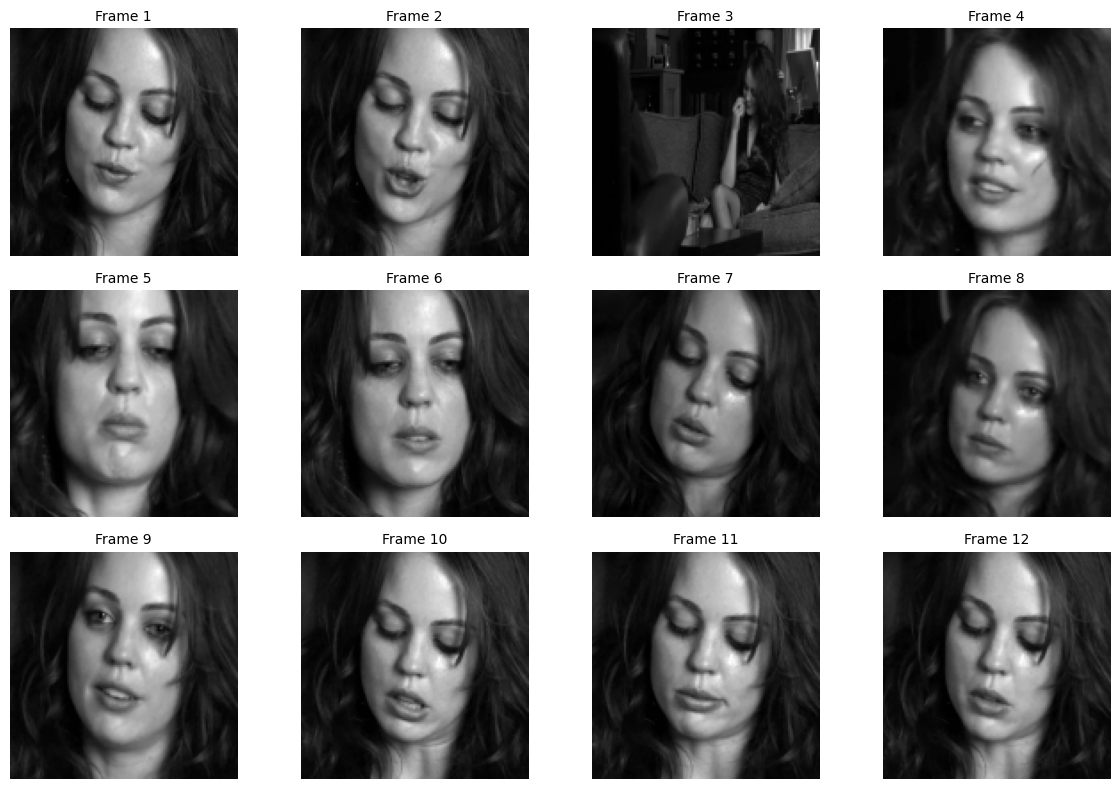

🔊 Playing audio:


🧩 Predicted Emotion:  joy
🗣️  Predicted Strategy: Communication Skills

================= RESULT SUMMARY =================
🧩 Predicted Emotion:  joy
🗣️  Predicted Strategy: Communication Skills
🎯 True Emotion:        joy
🎯 True Strategy:       Communication Skills


Dialogue_ID                                                     7
split_group                                                     3
Season                                                          1
Episode                                                         1
StartTime                                            00:12:34,594
EndTime                                              00:13:40,670
Speaker                                                    Client
Utterance       He unzipped, pulled down his pants, and he sto...
Emotion                                                       joy
Strategy                                     Communication Skills
Utterance_ID                                                    7
Frame_1         frames\Dialogue_ID-7_Season-1_Episode-1_f01_t0...
Frame_2         frames\Dialogue_ID-7_Season-1_Episode-1_f02_t0...
Frame_3         frames\Dialogue_ID-7_Season-1_Episode-1_f03_t0...
Frame_4         frames\Dialogue_ID-7_Season-1_Episode-1_f04_t0...
Frame_5   

In [ ]:

# Load trained model and encoders first (if not already)
model_loaded = Net().to(device)
model_loaded.load_state_dict(torch.load("robust_avt_model.pth", map_location=device))
model_loaded.eval()

# Now predict on a random CSV row
show_prediction_sample(model_loaded, df, le_e, le_s)

